# low cost HOSVD (Soledad's version)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os

from tensor_decompositions import (
    subsampled_hosvd, 
    low_cost_hosvd, 
    reconstruct_tensor, 
    compute_error,
    compute_compression_factor
)


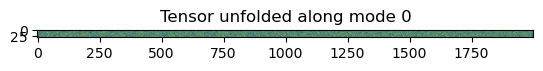

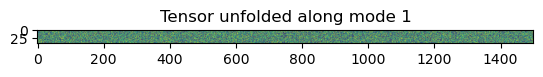

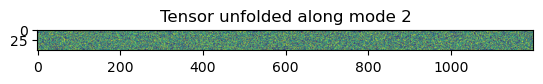

<Figure size 640x480 with 0 Axes>

In [2]:
path_figs = "./FULL_EXPLANATION"
tensor = np.random.rand(30,40,50)
for i in range(tensor.ndim):
    plt.title(f"Tensor unfolded along mode {i}")
    plt.imshow(tl.unfold(tensor=tensor, mode=i))
    sampled_indices = np.arange(0, tensor.shape[2], 2)  # [0, 2, 4, ..., 48]

    plt.figure()

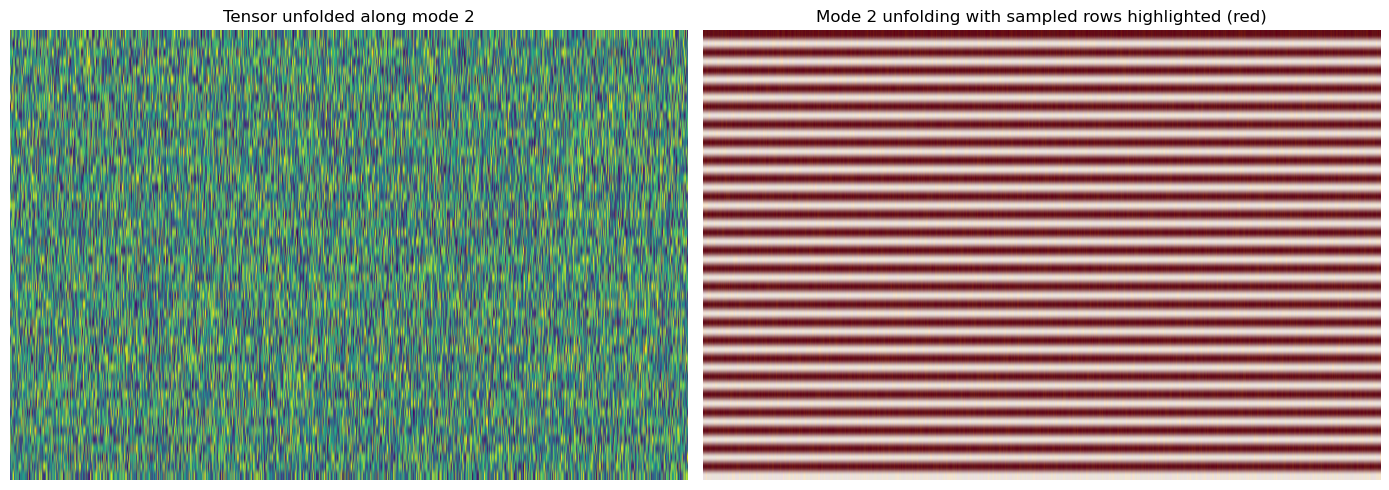

In [3]:
path_figs = "./FULL_EXPLANATION"
tensor = np.random.rand(30, 40, 50)
sampled_indices = np.arange(0, tensor.shape[2], 2)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
unfolded = tl.unfold(tensor=tensor, mode=2)
axes[0].set_title(f"Tensor unfolded along mode 2")
axes[0].imshow(unfolded, aspect='auto')
axes[0].axis('off')

axes[1].set_title(f"Mode 2 unfolding with sampled rows highlighted (red)")
axes[1].imshow(unfolded, aspect='auto')
mask = np.copy(unfolded)
mask[sampled_indices, :] = 10
axes[1].imshow(mask, aspect='auto', cmap='Reds')
axes[1].imshow(unfolded, alpha=0.1, aspect='auto')
axes[1].axis('off')

plt.tight_layout()
plt.savefig(f'{path_figs}/mode2_unfolding_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# HOSVD con campionamento

(30, 160)
(40, 120)
(50, 96)
0.03343605995178223
True


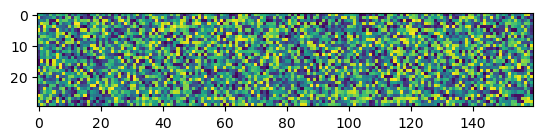

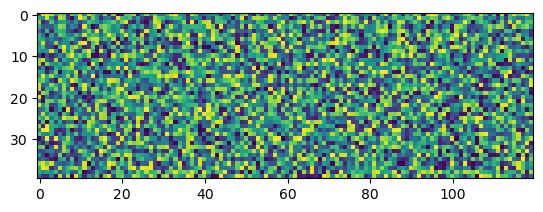

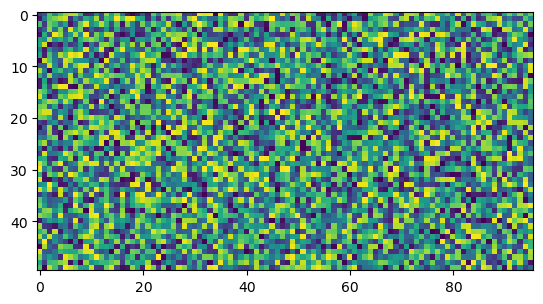

<Figure size 640x480 with 0 Axes>

In [4]:
sampling_ratio = 0.08
t_start = time.time()
factors = []
for mode in range(tensor.ndim):
    unfolded = tl.unfold(tensor, mode)
    m, n = unfolded.shape
    n_samples = int(n * sampling_ratio)        
    sample_indices = np.random.choice(n, size=n_samples, replace=False)
    sampled_matrix = unfolded[:, sample_indices]
    plt.imshow(sampled_matrix)
    plt.figure()
    print(sampled_matrix.shape)
    U, _, _ = np.linalg.svd(sampled_matrix, full_matrices=False)    
    factors.append(U)
core = tl.tenalg.multi_mode_dot(tensor, [U.T for U in factors], modes = [mode for mode in range(tensor.ndim)])
t_end = time.time()
print(t_end - t_start)

reconst = tl.tenalg.multi_mode_dot(core, factors, modes = [mode for mode in range(tensor.ndim)])
print(np.allclose(tensor, reconst))

# HOSVD a basso costo

Senza correzione del segno e riortogonalizzazione, ma l'idea principale rimane la stessa

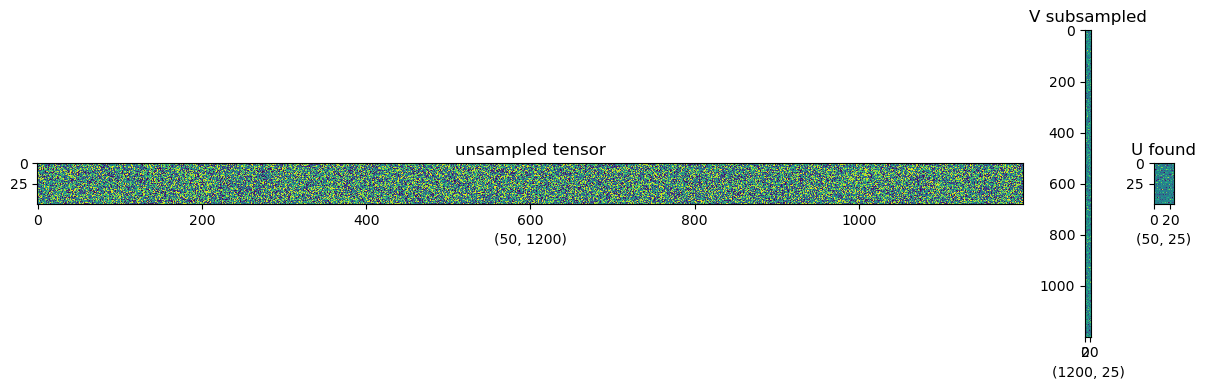

Time: 0.2677476406097412
False


In [5]:
t_start = time.time()
subsampled_tensor = tensor[:, :, ::2]
factors_lc = []

for mode in range(tensor.ndim):
    unfolded = tl.unfold(subsampled_tensor, mode)
    
    if mode != tensor.ndim - 1:
        U, _, _ = np.linalg.svd(unfolded, full_matrices=False)    
    else:
        U_red, sigma, V_red = np.linalg.svd(unfolded, full_matrices=False)        
        Q, R = np.linalg.qr(U_red)
        U_red = U_red @ np.linalg.inv(R)
        Q, R = np.linalg.qr(V_red.T)
        V_red = (V_red.T @ np.linalg.inv(R)).T
        ss = U_red.T @ unfolded @ V_red.T
        ss_sign = np.sign(np.diag(ss))
        V_red = V_red.T @ np.diag(ss_sign)
        V_red = V_red.T
        non_sampled_unfolded = tl.unfold(tensor, mode)
        U = non_sampled_unfolded @ V_red.T @ np.diag(1/sigma)
        Q, _ = np.linalg.qr(U)
        U = Q
        matrices = [non_sampled_unfolded,V_red.T,  U]

        widths = [m.shape[1] for m in matrices]

        fig, ax = plt.subplots(
            1, 3,
            figsize=(12, 4),
            gridspec_kw={'width_ratios': widths}
        )

        titles = ["unsampled tensor","V subsampled",  "U found"]

        for a, M, title in zip(ax, matrices, titles):
            a.imshow(M, aspect='equal', interpolation='none')
            a.set_title(title)
            a.set_xlabel(str(M.shape))

        plt.tight_layout()
        plt.savefig(fname = path_figs + "/matrices_product.png")
    
        plt.show()
    factors_lc.append(U)
core = tl.tenalg.multi_mode_dot(tensor, [U.T for U in factors_lc],modes=[mode for mode in range(tensor.ndim)])
t_end = time.time()
print(f"Time: {t_end - t_start}")

reconst_lc = tl.tenalg.multi_mode_dot(core, factors_lc, modes=[mode for mode in range(tensor.ndim)])
print(np.allclose(tensor, reconst_lc))

In [6]:

reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 10,10
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, 3, :]


Grid: 1600x2000, Subsampled: 160x200


100%|██████████| 200/200 [00:07<00:00, 26.90it/s]

(30, 40, 50)
Data loading complete!


# Confronto delle prestazioni: sweep della dimensione del tensore

Confronto dei tempi di calcolo per HOSVD a basso costo vs HOSVD con campionamento al variare delle dimensioni del tensore

Running tensor size sweep...
------------------------------------------------------------


100%|██████████| 50/50 [00:08<00:00,  5.62it/s]



Sweep complete!


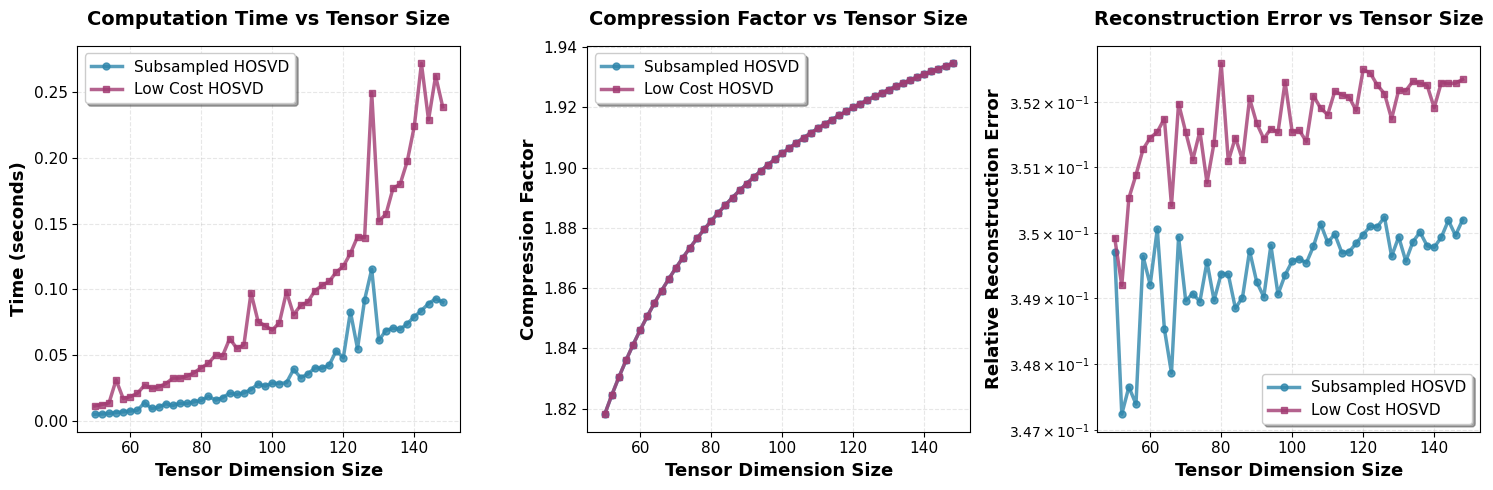


SUMMARY STATISTICS

Time Comparison:
  Average speedup (Subsampled/Low Cost): 0.40x
  Median speedup (Subsampled/Low Cost): 0.39x
  Min speedup: 0.20x
  Max speedup: 0.66x

Compression Factor Comparison:
  Subsampled HOSVD - Average: 1.90x, Min: 1.82x, Max: 1.93x
  Low Cost HOSVD - Average: 1.90x, Min: 1.82x, Max: 1.93x

Reconstruction Error Comparison:
  Subsampled HOSVD - Average: 3.49e-01, Min: 3.47e-01, Max: 3.50e-01
  Low Cost HOSVD - Average: 3.52e-01, Min: 3.49e-01, Max: 3.53e-01


In [7]:

base_size = 50
increment = 2
num_sizes = 50
sampling_ratio = 0.08

sizes = []
times_subsampled = []
times_low_cost = []
compression_factors_subsampled = []
compression_factors_low_cost = []
reconstruction_errors_subsampled = []
reconstruction_errors_low_cost = []

print("Running tensor size sweep...")
print("-" * 60)

for i in tqdm(range(num_sizes)):
    current_size = base_size + i * increment
    n1, n2, n3 = current_size, current_size, current_size
    sizes.append(current_size)
    
    test_tensor = np.random.rand(n1, n2, n3)
    
    core_sub, factors_sub, t_subsampled = subsampled_hosvd(test_tensor, sampling_ratio, time_it=True, sv_threshold=1e-10)

    factors_sub[0] = factors_sub[0][:, :factors_sub[0].shape[1]//2]
    core_sub = core_sub[:core_sub.shape[0]//2, :, :]
    
    times_subsampled.append(t_subsampled)
    compression_factor_sub = compute_compression_factor(test_tensor, core_sub, factors_sub)
    compression_factors_subsampled.append(compression_factor_sub)
    reconst_sub = reconstruct_tensor(core_sub, factors_sub)
    error_sub = compute_error(test_tensor, reconst_sub)
    reconstruction_errors_subsampled.append(error_sub)
    
    core_lc, factors_lc, t_lc = low_cost_hosvd(test_tensor, time_it=True, sampling_fraction=0.5, mode_fraction=1)
    times_low_cost.append(t_lc)
    
    compression_factor_lc = compute_compression_factor(test_tensor, core_lc, factors_lc)
    compression_factors_low_cost.append(compression_factor_lc)
    reconst_lc = reconstruct_tensor(core_lc, factors_lc)
    error_lc = compute_error(test_tensor, reconst_lc)
    reconstruction_errors_low_cost.append(error_lc)

print("\n" + "=" * 60)
print("Sweep complete!")

fig = plt.figure(figsize=(15, 5))

colors = ['#2E86AB', '#A23B72']

plt.subplot(1, 3, 1)
plt.plot(sizes, times_subsampled, 'o-', label='Subsampled HOSVD', 
         linewidth=2.5, markersize=5, color=colors[0], alpha=0.8)
plt.plot(sizes, times_low_cost, 's-', label='Low Cost HOSVD', 
         linewidth=2.5, markersize=5, color=colors[1], alpha=0.8)
plt.xlabel('Tensor Dimension Size', fontsize=13, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=13, fontweight='bold')
plt.title('Computation Time vs Tensor Size', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tick_params(labelsize=11)

plt.subplot(1, 3, 2)
plt.plot(sizes, compression_factors_subsampled, 'o-', label='Subsampled HOSVD', 
         linewidth=2.5, markersize=5, color=colors[0], alpha=0.8)
plt.plot(sizes, compression_factors_low_cost, 's-', label='Low Cost HOSVD', 
         linewidth=2.5, markersize=5, color=colors[1], alpha=0.8)
plt.xlabel('Tensor Dimension Size', fontsize=13, fontweight='bold')
plt.ylabel('Compression Factor', fontsize=13, fontweight='bold')
plt.title('Compression Factor vs Tensor Size', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tick_params(labelsize=11)

plt.subplot(1, 3, 3)
plt.plot(sizes, reconstruction_errors_subsampled, 'o-', label='Subsampled HOSVD', 
         linewidth=2.5, markersize=5, color=colors[0], alpha=0.8)
plt.plot(sizes, reconstruction_errors_low_cost, 's-', label='Low Cost HOSVD', 
         linewidth=2.5, markersize=5, color=colors[1], alpha=0.8)
plt.xlabel('Tensor Dimension Size', fontsize=13, fontweight='bold')
plt.ylabel('Relative Reconstruction Error', fontsize=13, fontweight='bold')
plt.title('Reconstruction Error vs Tensor Size', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--', which='both')
plt.yscale('log')
plt.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('full_comparison_sweep.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nTime Comparison:")
print(f"  Average speedup (Subsampled/Low Cost): {np.mean(np.array(times_subsampled)/np.array(times_low_cost)):.2f}x")
print(f"  Median speedup (Subsampled/Low Cost): {np.median(np.array(times_subsampled)/np.array(times_low_cost)):.2f}x")
print(f"  Min speedup: {np.min(np.array(times_subsampled)/np.array(times_low_cost)):.2f}x")
print(f"  Max speedup: {np.max(np.array(times_subsampled)/np.array(times_low_cost)):.2f}x")

print(f"\nCompression Factor Comparison:")
print(f"  Subsampled HOSVD - Average: {np.mean(compression_factors_subsampled):.2f}x, Min: {np.min(compression_factors_subsampled):.2f}x, Max: {np.max(compression_factors_subsampled):.2f}x")
print(f"  Low Cost HOSVD - Average: {np.mean(compression_factors_low_cost):.2f}x, Min: {np.min(compression_factors_low_cost):.2f}x, Max: {np.max(compression_factors_low_cost):.2f}x")

print(f"\nReconstruction Error Comparison:")
print(f"  Subsampled HOSVD - Average: {np.mean(reconstruction_errors_subsampled):.2e}, Min: {np.min(reconstruction_errors_subsampled):.2e}, Max: {np.max(reconstruction_errors_subsampled):.2e}")
print(f"  Low Cost HOSVD - Average: {np.mean(reconstruction_errors_low_cost):.2e}, Min: {np.min(reconstruction_errors_low_cost):.2e}, Max: {np.max(reconstruction_errors_low_cost):.2e}")

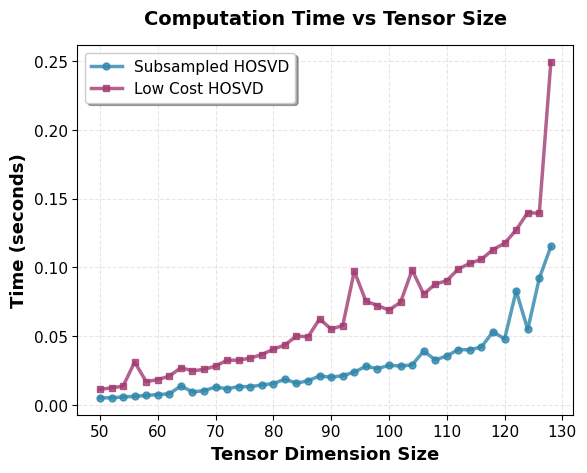

In [8]:
plt.plot(sizes[:-10], times_subsampled[:-10], 'o-', label='Subsampled HOSVD', 
         linewidth=2.5, markersize=5, color=colors[0], alpha=0.8)
plt.plot(sizes[:-10], times_low_cost[:-10], 's-', label='Low Cost HOSVD', 
         linewidth=2.5, markersize=5, color=colors[1], alpha=0.8)
plt.xlabel('Tensor Dimension Size', fontsize=13, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=13, fontweight='bold')
plt.title('Computation Time vs Tensor Size', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tick_params(labelsize=11)

# Grafici 4 5 6 7

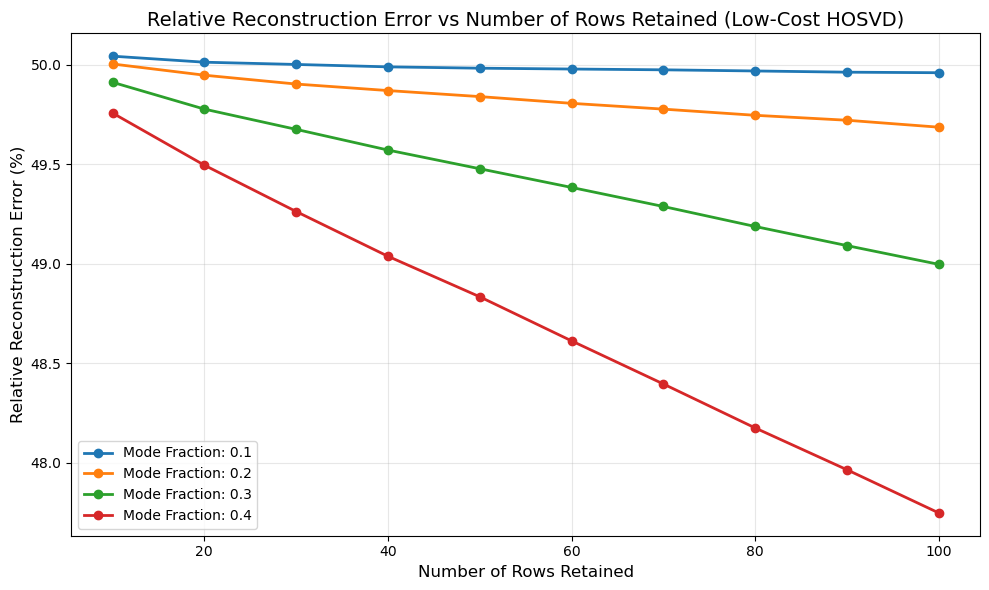

In [9]:
test_tensor = np.random.rand(100, 100, 100)
sampling_parameters = [i*0.1 for i in range(1,11)] 
modes_retained = [i*0.1 for i in range(1,5)]  

plt.figure(figsize=(10, 6))

for mode_fraction in modes_retained:
    results = {}
    for sampling_fraction in sampling_parameters:
        core, factors, t = low_cost_hosvd(test_tensor, time_it=True, 
                                          sampling_fraction=sampling_fraction, 
                                          mode_fraction=mode_fraction)
        n_rows_retained = int(sampling_fraction * test_tensor.shape[-1])
        error = compute_error(test_tensor, reconstruct_tensor(core, factors))
        results[n_rows_retained] = error * 100  
    
    plt.plot(results.keys(), results.values(), marker='o', linewidth=2, 
             label=f'Mode Fraction: {mode_fraction:.1f}')

plt.xlabel('Number of Rows Retained', fontsize=12)
plt.ylabel('Relative Reconstruction Error (%)', fontsize=12)
plt.title('Relative Reconstruction Error vs Number of Rows Retained (Low-Cost HOSVD)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

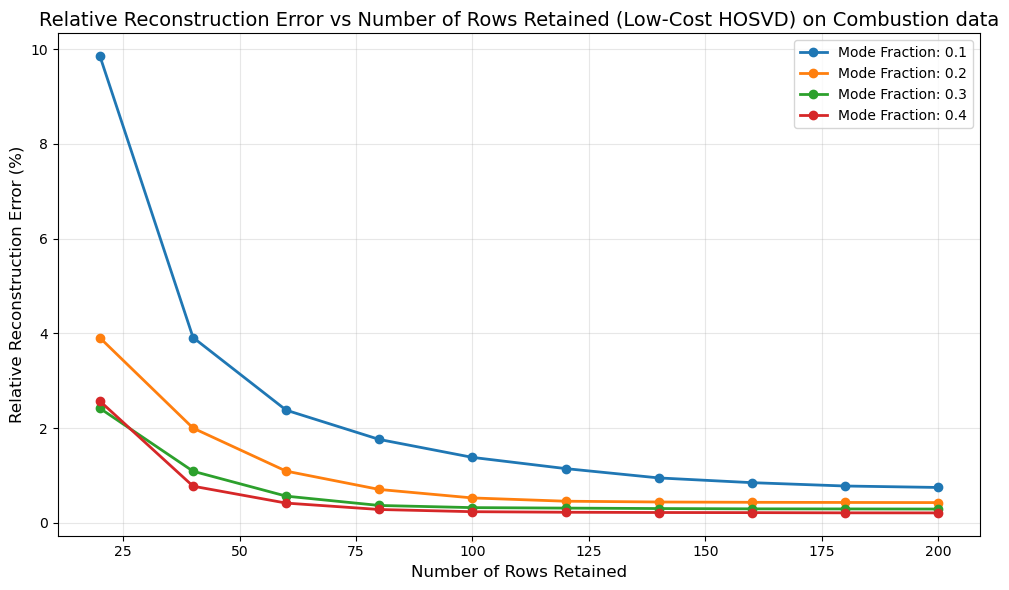

In [10]:
sampling_parameters = [i*0.1 for i in range(1,11)] 
modes_retained = [i*0.1 for i in range(1,5)]  

plt.figure(figsize=(10, 6))

for mode_fraction in modes_retained:
    results = {}
    for sampling_fraction in sampling_parameters:
        core, factors, t = low_cost_hosvd(tensor_combustion, time_it=True, 
                                          sampling_fraction=sampling_fraction, 
                                          mode_fraction=mode_fraction)
        n_rows_retained = int(sampling_fraction * tensor_combustion.shape[-1])
        error = compute_error(tensor_combustion, reconstruct_tensor(core, factors))
        results[n_rows_retained] = error * 100  
    
    plt.plot(results.keys(), results.values(), marker='o', linewidth=2, 
             label=f'Mode Fraction: {mode_fraction:.1f}')

plt.xlabel('Number of Rows Retained', fontsize=12)
plt.ylabel('Relative Reconstruction Error (%)', fontsize=12)
plt.title('Relative Reconstruction Error vs Number of Rows Retained (Low-Cost HOSVD) on Combustion data', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

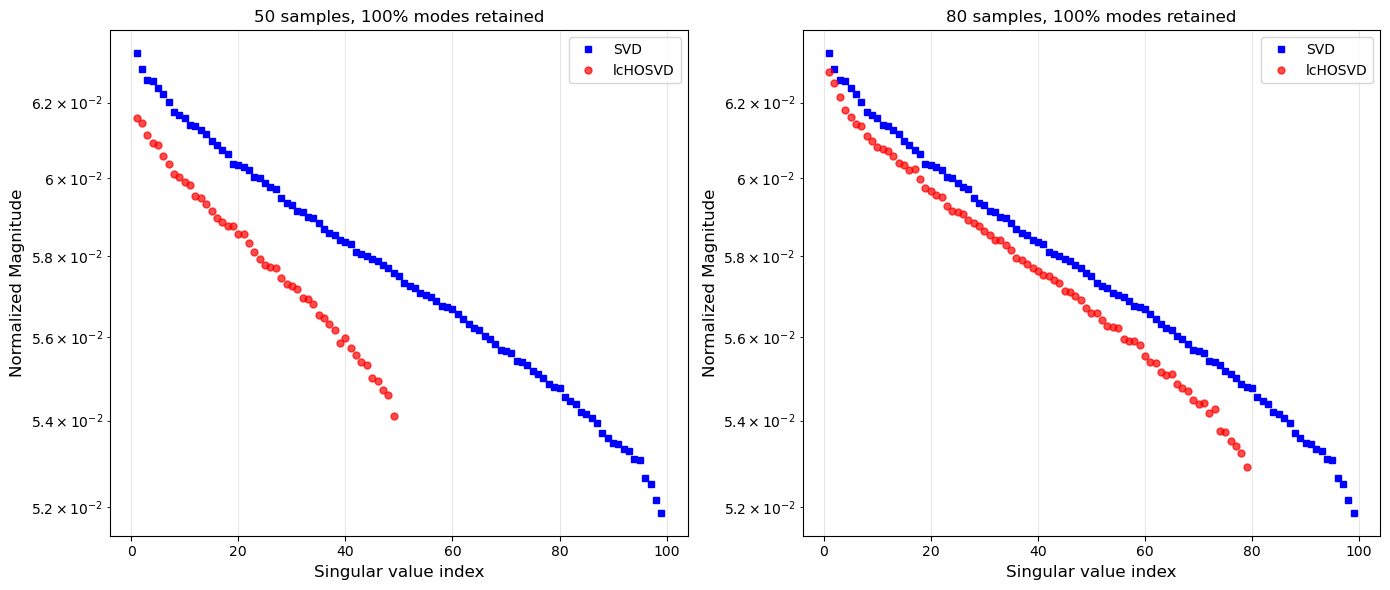

In [11]:
test_tensor = np.random.rand(100, 100, 100)
sampling_parameters = [0.5, 0.8] 
mode_fraction = 1.0  

plt.figure(figsize=(14, 6))

for idx, sampling_fraction in enumerate(sampling_parameters, 1):
    plt.subplot(1, 2, idx)
    
    core_lc, factors_lc, t_lc = low_cost_hosvd(test_tensor, time_it=True, 
                                                sampling_fraction=sampling_fraction, 
                                                mode_fraction=mode_fraction)
    
    ranks = [int(s * mode_fraction) for s in test_tensor.shape]
    core_std, factors_std = tl.decomposition.tucker(test_tensor, rank=ranks)
    
    sv_lc = []
    for i in range(core_lc.shape[0]):
        sv_lc.append(np.linalg.norm(core_lc[i, :, :]))
    
    sv_std = []
    for i in range(core_std.shape[0]):
        sv_std.append(np.linalg.norm(core_std[i, :, :]))
    
    sv_lc = np.array(sv_lc)
    sv_std = np.array(sv_std)
    
    max_val = max(np.max(sv_lc) if len(sv_lc) > 0 else 0, 
                  np.max(sv_std) if len(sv_std) > 0 else 0)
    
    if max_val > 0:
        sv_lc = sv_lc / max_val
        sv_std = sv_std / max_val
    
    plt.plot(range(1, len(sv_std)), sv_std[1:], 's', color='blue', 
             label='SVD', markersize=4, markerfacecolor='blue')
    plt.plot(range(1,len(sv_lc)), sv_lc[1:], 'o', color='red', 
             label='lcHOSVD', markersize=5, markerfacecolor='red', alpha=0.7)
    
    plt.xlabel('Singular value index', fontsize=12)
    plt.ylabel('Normalized Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    
    n_samples = int(sampling_fraction * test_tensor.shape[0])
    plt.title(f'{n_samples} samples, {int(mode_fraction*100)}% modes retained', fontsize=12)
    plt.yscale('log')
plt.tight_layout()
plt.show()

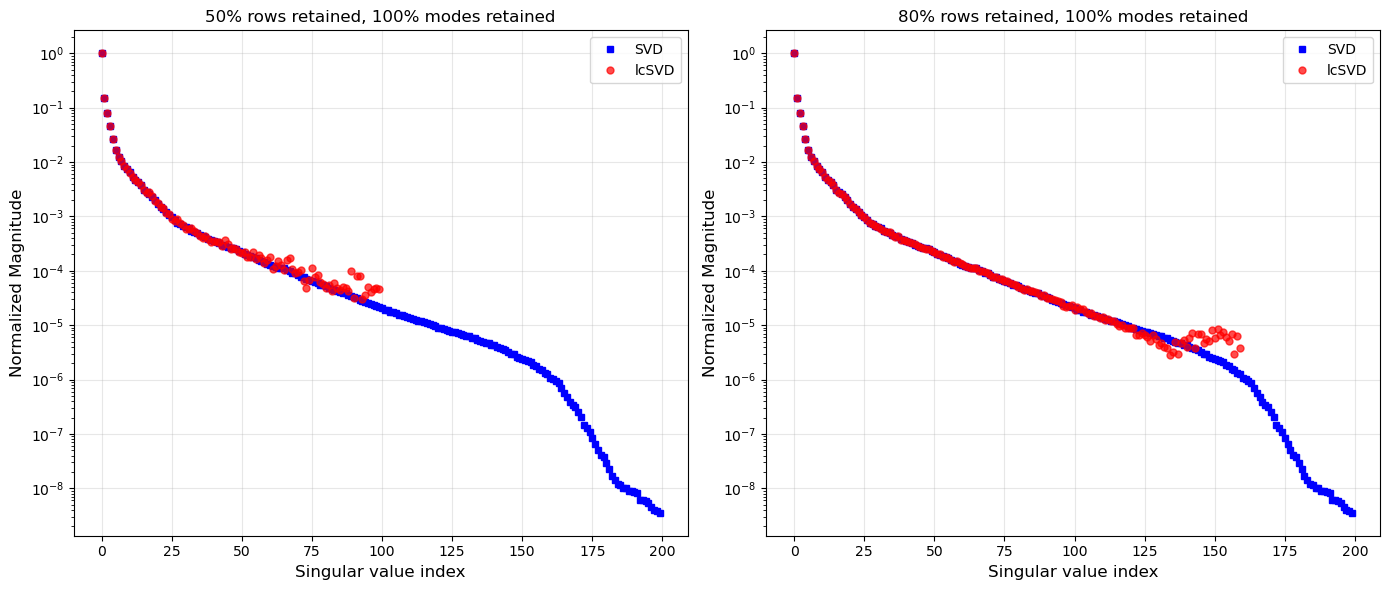

In [12]:
test_tensor = tensor_combustion
sampling_parameters = [0.5, 0.8]
mode_fraction = 1

plt.figure(figsize=(14, 6))

for idx, sampling_fraction in enumerate(sampling_parameters, 1):
    plt.subplot(1, 2, idx)
    
    core_lc, factors_lc, t_lc = low_cost_hosvd(test_tensor, time_it=True, 
                                                sampling_fraction=sampling_fraction, 
                                                mode_fraction=mode_fraction)
    
    core_std, factors_std = low_cost_hosvd(test_tensor, time_it=False, 
                                                sampling_fraction=1, 
                                                mode_fraction=mode_fraction)
    
    sv_lc = []
    for i in range(core_lc.shape[0]):
        sv_lc.append(np.linalg.norm(core_lc[i, :, :]))
    
    sv_std = []
    for i in range(core_std.shape[0]):
        sv_std.append(np.linalg.norm(core_std[i, :, :]))
    
    sv_lc = np.array(sv_lc)
    sv_std = np.array(sv_std)
    
    max_val = max(np.max(sv_lc) if len(sv_lc) > 0 else 0, 
                  np.max(sv_std) if len(sv_std) > 0 else 0)
    
    if max_val > 0:
        sv_lc = sv_lc / max_val
        sv_std = sv_std / max_val
    
    plt.plot(range(0, len(sv_std)), sv_std, 's', color='blue', 
             label='SVD', markersize=4, markerfacecolor='blue')
    plt.plot(range(0,len(sv_lc)), sv_lc, 'o', color='red', 
             label='lcSVD', markersize=5, markerfacecolor='red', alpha=0.7)
    
    plt.xlabel('Singular value index', fontsize=12)
    plt.ylabel('Normalized Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    
    plt.title(f'{int(sampling_fraction*100)}% rows retained, {int(mode_fraction*100)}% modes retained', fontsize=12)
    plt.yscale('log')

plt.tight_layout()
plt.show()

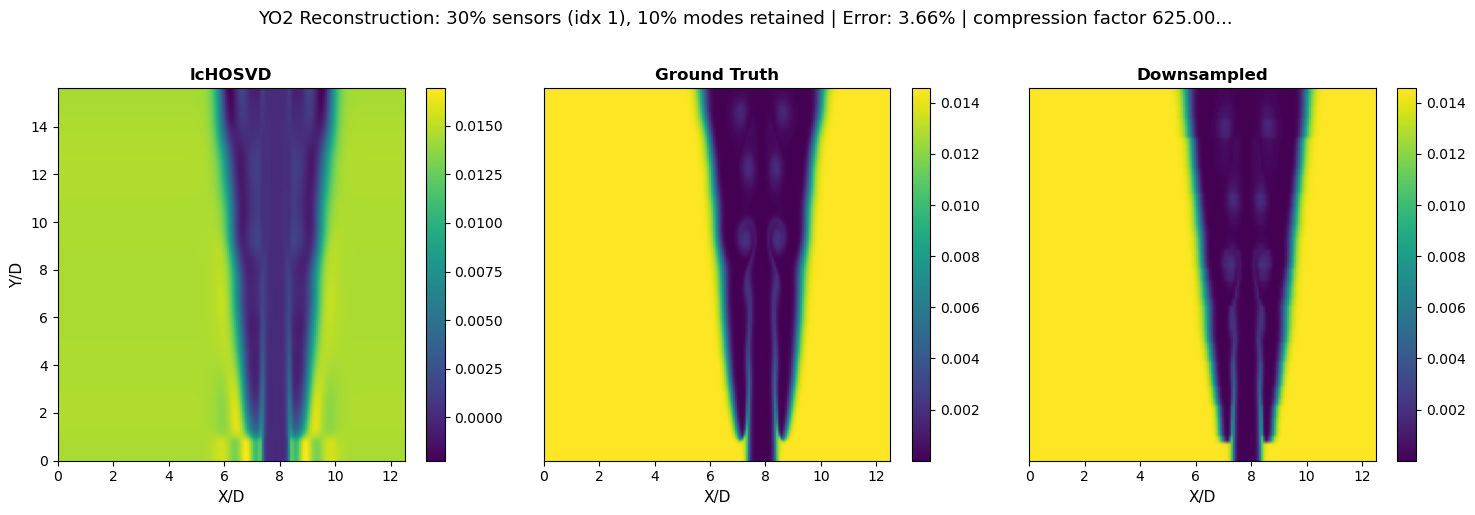

(20, 4, 20) (200, 160, 200)
[(200, 20), (160, 4), (200, 20)] [(200, 200), (160, 160), (200, 200)]
Compression_factor: 625.00


In [13]:
test_tensor = tensor_combustion
sampling_fraction = 0.3
mode_fraction = 0.1

core_lc, factors_lc, t_lc = low_cost_hosvd(test_tensor, time_it=True, 
                                            sampling_fraction=sampling_fraction, 
                                            mode_fraction=mode_fraction, special_mode=1)
reconstruction_lc = reconstruct_tensor(core_lc, factors_lc)

n_samples = max(1, int(test_tensor.shape[0] * sampling_fraction))
sampled_indices = np.random.choice(test_tensor.shape[0], size=n_samples, replace=False)
sampled_indices = np.sort(sampled_indices)
downsampled = test_tensor[sampled_indices, :, :]

snap_idx = n_snapshots // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(reconstruction_lc[:, :, snap_idx], 
                     aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, Lx, 0, Ly])
axes[0].set_title('lcHOSVD', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Y/D', fontsize=11)
axes[0].set_xlabel('X/D', fontsize=11)
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(test_tensor[:, :, snap_idx], 
                     aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, Lx, 0, Ly])
axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
axes[1].set_xlabel('X/D', fontsize=11)
axes[1].set_yticks([])
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(downsampled[:, :, snap_idx], 
                     aspect='auto', origin='lower', cmap='viridis',
                     extent=[0, Lx, 0, Ly])
axes[2].set_title('Downsampled', fontsize=12, fontweight='bold')
axes[2].set_xlabel('X/D', fontsize=11)
axes[2].set_yticks([])
plt.colorbar(im3, ax=axes[2])
compression_factor = compute_compression_factor(tensor_combustion, core_lc, factors_lc)

error = compute_error(test_tensor, reconstruction_lc)
fig.suptitle(f'YO2 Reconstruction: {int(sampling_fraction*100)}% sensors (idx 1), {int(mode_fraction*100)}% modes retained | Error: {error*100:.2f}% | compression factor {compression_factor:.2f}...', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()
compression_factor = compute_compression_factor(tensor_combustion, core_lc, factors_lc)
print(core_lc.shape, core_std.shape)
print([f.shape for f in factors_lc], [f.shape for f in factors_std])
print(f"Compression_factor: {compression_factor:.2f}")

# New algorithm

In [16]:

reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]


Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:10<00:00, 19.60it/s]

(30, 40, 50)
Data loading complete!


(400, 320, 8, 200)
(400, 400)
(320, 320)
(8, 8)
(200, 200)


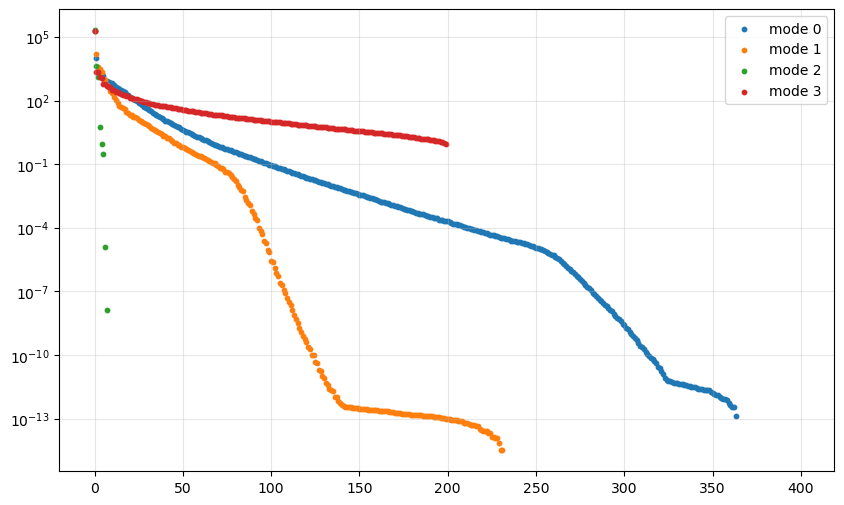

In [ ]:
factors_sub = []
test_tensor = tensor_combustion
sv_threshold = 1e-03
print(test_tensor.shape)

plt.figure(figsize=(10, 6))
for mode in range(test_tensor.ndim):
    unfolded = tl.unfold(test_tensor, mode)
    m, n = unfolded.shape
    g_matrix = unfolded @ unfolded.T
    print(g_matrix.shape)
    eigens = np.linalg.eigvals(g_matrix)
    eigens = np.sort(np.real(eigens))[::-1]
    plt.scatter(range(len(eigens)), eigens, label=f"mode {mode}", s=10)

plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## Selezione dei modi ancora da decidere, per ora lo tengo con quello che ha il maggior numero di autovalori

In [ ]:
factors_sub = []
test_tensor = tensor_combustion
sv_threshold = 1e-03

print(test_tensor.shape)

ranks_above_threshold = []
for mode in range(test_tensor.ndim):
    unfolded = tl.unfold(test_tensor, mode)

    g_matrix = unfolded @ unfolded.T
    U, = np.linalg.eig(unfolded, full_matrices=False)
    
    rank = np.sum(S > sv_threshold)
    ranks_above_threshold.append(rank)
    print(f"Mode {mode}: {rank} singular values above {sv_threshold}")

modes_to_truncate = np.argsort(ranks_above_threshold)[::-1][:2]  
print(f"\nTruncating modes: {modes_to_truncate}")

core = test_tensor
factors = []
for mode in range(test_tensor.ndim):
    unfolded = tl.unfold(core, mode)
    U, S, Vt = np.linalg.svd(unfolded, full_matrices=False)
    
    if mode in modes_to_truncate:
        rank = ranks_above_threshold[mode]
        U = U[:, :rank]
        print(f"Mode {mode}: truncating to rank {rank}")
    else:
        print(f"Mode {mode}: keeping full rank {U.shape[1]}")
    
    factors.append(U)
    core = tl.tenalg.mode_dot(core, U.T, mode)

print(f"\nCore shape: {core.shape}")

(400, 320, 8, 200)
Mode 0: 270 singular values above 0.001
Mode 1: 103 singular values above 0.001


KeyboardInterrupt: 

Original tensor norm: 4.5832e+02
Reconstructed tensor norm: 4.5521e+02
Absolute error: 5.3266e+01
Relative error: 0.116220 (11.622%)


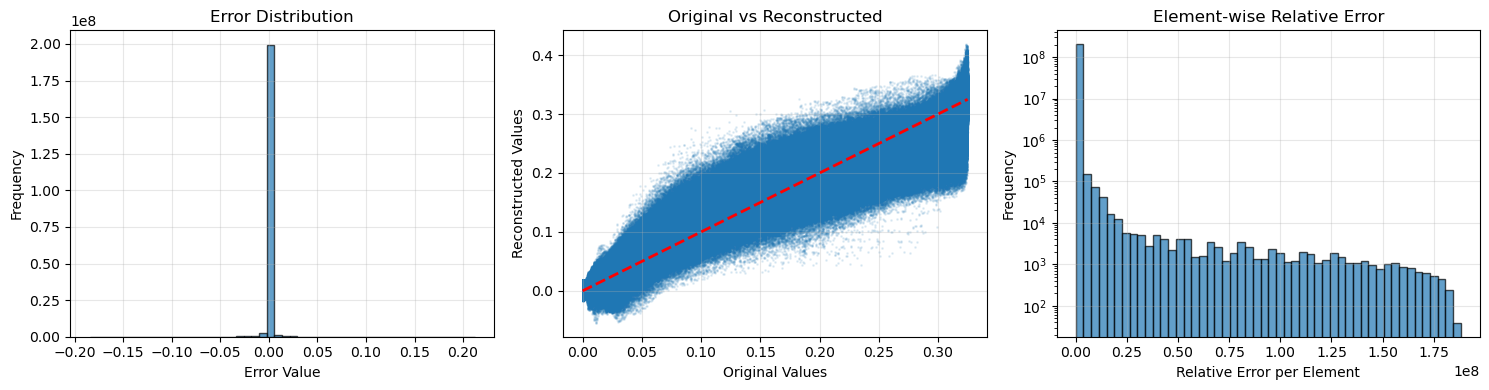

In [29]:
# Reconstruct the tensor
reconstructed = core
for mode in range(test_tensor.ndim):
    reconstructed = tl.tenalg.mode_dot(reconstructed, factors[mode], mode)

# Compute errors
absolute_error = np.linalg.norm(test_tensor - reconstructed)
relative_error = absolute_error / np.linalg.norm(test_tensor)
frobenius_norm_original = np.linalg.norm(test_tensor)
frobenius_norm_recon = np.linalg.norm(reconstructed)

print(f"Original tensor norm: {frobenius_norm_original:.4e}")
print(f"Reconstructed tensor norm: {frobenius_norm_recon:.4e}")
print(f"Absolute error: {absolute_error:.4e}")
print(f"Relative error: {relative_error:.6f} ({relative_error*100:.3f}%)")

# Visualize error distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of errors
error_flat = (test_tensor - reconstructed).flatten()
axes[0].hist(error_flat, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Error Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution')
axes[0].grid(True, alpha=0.3)

# Original vs Reconstructed values
original_flat = test_tensor.flatten()
recon_flat = reconstructed.flatten()
axes[1].scatter(original_flat, recon_flat, alpha=0.1, s=1)
axes[1].plot([original_flat.min(), original_flat.max()], 
             [original_flat.min(), original_flat.max()], 'r--', lw=2)
axes[1].set_xlabel('Original Values')
axes[1].set_ylabel('Reconstructed Values')
axes[1].set_title('Original vs Reconstructed')
axes[1].grid(True, alpha=0.3)

# Relative error per element (log scale)
rel_error_element = np.abs(error_flat) / (np.abs(original_flat) + 1e-10)
axes[2].hist(rel_error_element, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Relative Error per Element')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Element-wise Relative Error')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()